# NHL Goal Clustering - Graph-Based Approach

This notebook explores graph-based clustering methods for NHL goal data to create natural groupings that will form "galaxies" and "constellations" in the final visualization.

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import json
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

plt.style.use('dark_background')
sns.set_palette('viridis')

# Set random seed for reproducibility
np.random.seed(42)

## Data Exploration and Setup

In [56]:
# Load the NHL goals dataset
df = pd.read_csv('data/nhl_goals_with_names.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nMissing values:")
missing_info = df.isnull().sum()
missing_pct = (missing_info / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Count': missing_info, 'Percentage': missing_pct})
print(missing_df[missing_df['Count'] > 0])

Dataset shape: (391895, 17)

Columns: ['team_id', 'player_id', 'period', 'time', 'situation_code', 'x', 'y', 'url', 'shot_type', 'goalie', 'home_team_defending_side', 'team_score', 'opponent_score', 'game_date', 'team_name', 'player_name', 'goalie_name']

Missing values:
                           Count  Percentage
situation_code            279776       71.39
url                       376270       96.01
shot_type                 209706       53.51
goalie                     10430        2.66
home_team_defending_side  347305       88.62
goalie_name                10430        2.66


In [57]:
# Analyze coordinate availability
coord_available = ((df['x'] != 0) | (df['y'] != 0))
print(f"Goals with coordinates: {coord_available.sum()} ({coord_available.mean()*100:.1f}%)")
print(f"Goals without coordinates: {(~coord_available).sum()} ({(~coord_available).mean()*100:.1f}%)")

# Analyze URL availability by season
df['game_date'] = pd.to_datetime(df['game_date'])
df['season'] = df['game_date'].dt.year
url_by_season = df.groupby('season')['url'].apply(lambda x: (x.notna() & (x != '')).sum())
print("\nURL availability by season:")
print(url_by_season[url_by_season > 0])

Goals with coordinates: 112288 (28.7%)
Goals without coordinates: 279607 (71.3%)

URL availability by season:
season
2023    3459
2024    7971
2025    4195
Name: url, dtype: int64


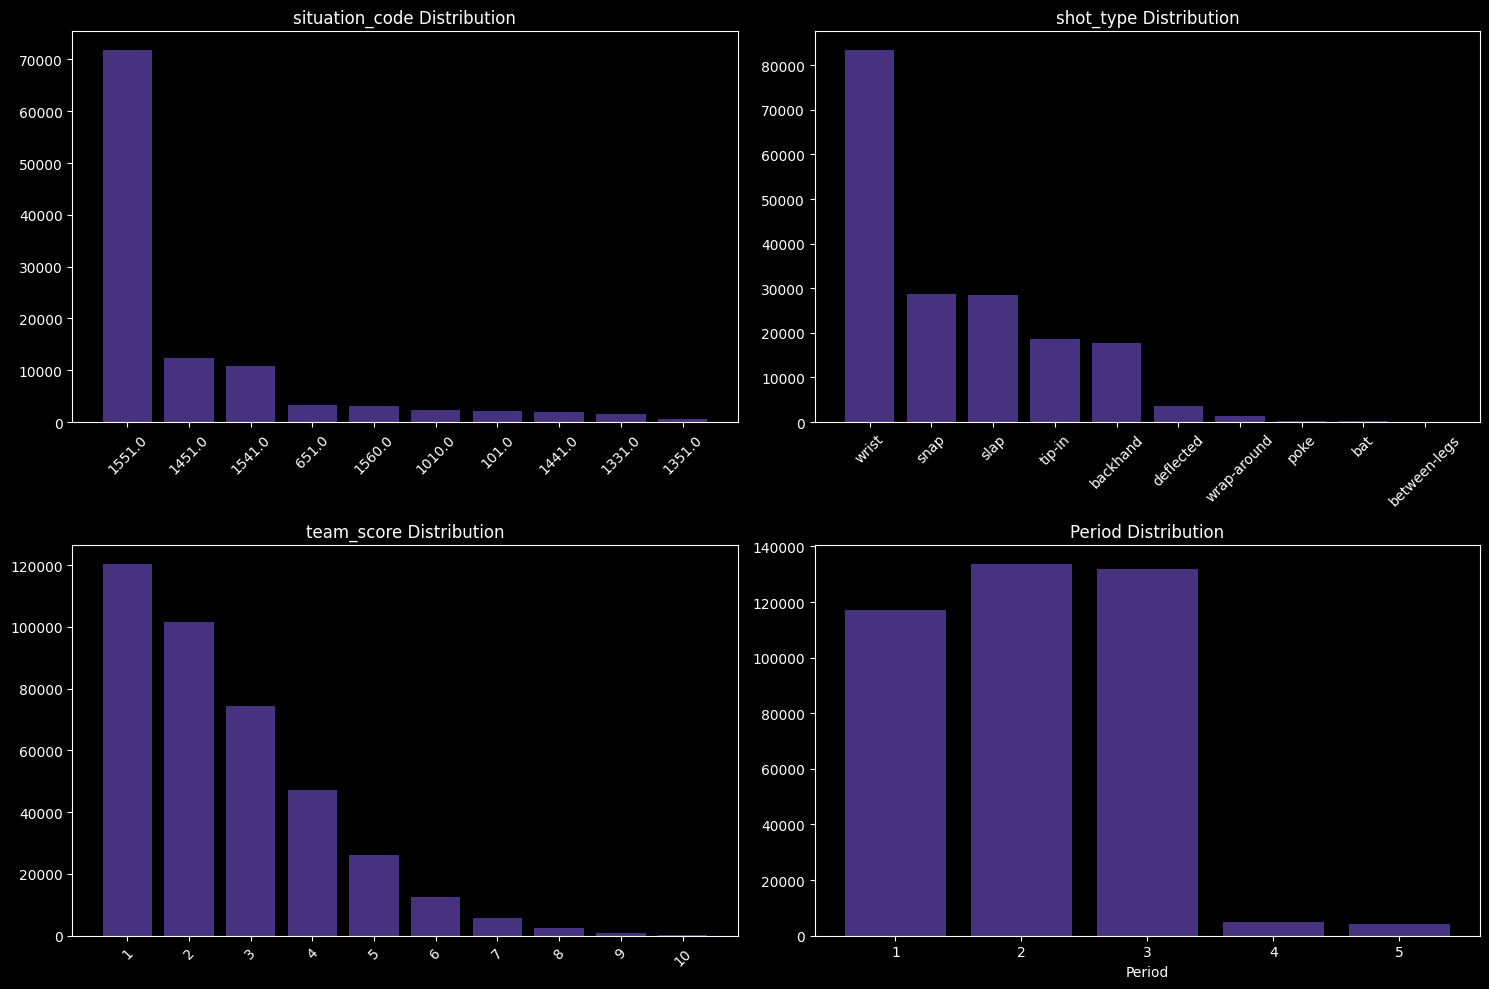

In [58]:
# Explore key categorical features
categorical_features = ['situation_code', 'shot_type', 'team_score']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(categorical_features):
    if feature in df.columns:
        value_counts = df[feature].value_counts().head(10)
        axes[i].bar(range(len(value_counts)), value_counts.values)
        axes[i].set_title(f'{feature} Distribution')
        axes[i].set_xticks(range(len(value_counts)))
        axes[i].set_xticklabels(value_counts.index, rotation=45)

# Period distribution
period_counts = df['period'].value_counts().sort_index()
axes[3].bar(period_counts.index, period_counts.values)
axes[3].set_title('Period Distribution')
axes[3].set_xlabel('Period')

plt.tight_layout()
plt.show()

## Feature Engineering for Graph Construction

In [70]:
def prepare_graph_features(df):
    """Prepare features for graph-based clustering"""
    
    features_df = df.copy()
    
    # Parse time to get total seconds in period
    time_parts = features_df['time'].str.split(':')
    features_df['time_minutes'] = time_parts.str[0].astype(float)
    features_df['time_seconds'] = time_parts.str[1].astype(float)
    features_df['total_seconds_in_period'] = features_df['time_minutes'] * 60 + features_df['time_seconds']
    
    # Create absolute game time (accounting for period)
    features_df['absolute_game_time'] = (features_df['period'] - 1) * 1200 + features_df['total_seconds_in_period']
    
    # Score context
    features_df['score_diff'] = (features_df['team_score']-1) - features_df['opponent_score']
    features_df['total_score'] = (features_df['team_score']-1) + features_df['opponent_score']

    # Game state categories
    features_df['game_state'] = 'tied'
    features_df.loc[features_df['score_diff'] > 0, 'game_state'] = 'leading'
    features_df.loc[features_df['score_diff'] < 0, 'game_state'] = 'trailing'
    
    # Coordinate availability flag
    features_df['has_coordinates'] = ((features_df['x'] != 0) | (features_df['y'] != 0))
    
    # Fill missing categorical values
    features_df['situation_code'] = features_df['situation_code'].fillna('unknown')
    features_df['shot_type'] = features_df['shot_type'].fillna('unknown')
    # using -1 for empty net goals
    features_df['goalie'] = features_df['goalie'].fillna(-1)

    # split date into year, month, day
    features_df['game_date'] = pd.to_datetime(features_df['game_date'])
    features_df['year'] = features_df['game_date'].dt.year
    features_df['month'] = features_df['game_date'].dt.month
    features_df['day'] = features_df['game_date'].dt.day

    # Add vector embeddings for player name, goalie name, and team name
    player_embeddings = pd.read_csv('data/player_embeddings.csv', index_col='player_id')
    team_embeddings = pd.read_csv('data/team_embeddings.csv', index_col='team_id')
    features_df = features_df.merge(player_embeddings, left_on='player_id', right_index=True, how='left', suffixes=('', '_player'))
    features_df = features_df.merge(player_embeddings, left_on='goalie', right_index=True, how='left', suffixes=('', '_goalie'))
    features_df = features_df.merge(team_embeddings, left_on='team_id', right_index=True, how='left', suffixes=('', '_team'))
    # convert embeddings back to numpy arrays
    features_df['embedding'] = features_df['embedding'].apply(lambda x: np.array(json.loads(x)))
    features_df['embedding_goalie'] = features_df['embedding_goalie'].apply(lambda x: np.array(json.loads(x)) if pd.notna(x) else np.zeros(player_embeddings.shape[1]))
    features_df['embedding_team'] = features_df['embedding_team'].apply(lambda x: np.array(json.loads(x)) if pd.notna(x) else np.zeros(team_embeddings.shape[1]))


    return features_df

graph_df = prepare_graph_features(df)
# Filter out goals with coordinates
graph_df = graph_df[~graph_df['has_coordinates']]
print(f"Prepared {len(graph_df)} goals for graph analysis")
print(f"New features: {[col for col in graph_df.columns if col not in df.columns]}")

Prepared 279607 goals for graph analysis
New features: ['time_minutes', 'time_seconds', 'total_seconds_in_period', 'absolute_game_time', 'score_diff', 'total_score', 'game_state', 'has_coordinates', 'year', 'month', 'day', 'embedding', 'embedding_goalie', 'embedding_team']


In [71]:
graph_df.columns

Index(['team_id', 'player_id', 'period', 'time', 'situation_code', 'x', 'y',
       'url', 'shot_type', 'goalie', 'home_team_defending_side', 'team_score',
       'opponent_score', 'game_date', 'team_name', 'player_name',
       'goalie_name', 'season', 'time_minutes', 'time_seconds',
       'total_seconds_in_period', 'absolute_game_time', 'score_diff',
       'total_score', 'game_state', 'has_coordinates', 'year', 'month', 'day',
       'embedding', 'embedding_goalie', 'embedding_team'],
      dtype='object')

## Similarity Metrics Implementation

In [155]:
class GoalSimilarity:
    """Class to compute various similarity metrics between NHL goals"""
    
    def __init__(self, df, features=[]):
        self.df = df
        self.features = features.copy()  # Make a copy to avoid modifying the original
        self.n_goals = len(df)
        self.scale = StandardScaler()
        self.full_features_used = 0
        
        # Separate features into scalar and embedding columns
        self.embedding_cols = ['embedding', 'embedding_goalie', 'embedding_team']
        self.scalar_features = []
        self.embedding_features = []
        
        # Categorize features
        for feature in self.features:
            if feature in self.embedding_cols:
                self.embedding_features.append(feature)
            else:
                self.scalar_features.append(feature)
        
        # Encode categorical features
        self.label_encoders = {}
        self.categorical_cols = ['situation_code', 'shot_type', 'game_state']

        for col in self.categorical_cols:
            if col in df.columns and col in self.scalar_features:
                le = LabelEncoder()
                feature_name = f'{col}_encoded'
                self.df[f'{col}_encoded'] = le.fit_transform(df[col].fillna('unknown').astype(str))
                self.label_encoders[col] = le
                # Replace the categorical column with the encoded version
                self.scalar_features.remove(col)
                self.scalar_features.append(feature_name)

        # Only fit StandardScaler on scalar features (excluding embeddings)
        if self.scalar_features:
            self.scale.fit(self.df[self.scalar_features].fillna(0))
        
        print(f"Initialized with {len(self.scalar_features)} scalar features and {len(self.embedding_features)} embedding features")
        print(f"Scalar features: {self.scalar_features}")
        print(f"Embedding features: {self.embedding_features}")
    
    def cosine_similarity(self, i, j):
        """Compute cosine similarity based on encoded features and embeddings"""
        goal_i = self.df.iloc[i]
        goal_j = self.df.iloc[j]
        
        # Extract scalar features
        scalar_features_i = np.array([goal_i[col] for col in self.scalar_features if col in goal_i])
        scalar_features_j = np.array([goal_j[col] for col in self.scalar_features if col in goal_j])
        
        # Scale scalar features
        if len(scalar_features_i) > 0:
            scalar_features_i = self.scale.transform(scalar_features_i.reshape(1, -1))[0]
            scalar_features_j = self.scale.transform(scalar_features_j.reshape(1, -1))[0]
        
        # Extract and flatten embedding features
        embedding_features_i = []
        embedding_features_j = []
        
        for col in self.embedding_features:
            if col in goal_i and goal_i[col] is not None:
                embedding_i = goal_i[col] if isinstance(goal_i[col], np.ndarray) else np.array(goal_i[col])
                embedding_features_i.extend(embedding_i.flatten())
            if col in goal_j and goal_j[col] is not None:
                embedding_j = goal_j[col] if isinstance(goal_j[col], np.ndarray) else np.array(goal_j[col])
                embedding_features_j.extend(embedding_j.flatten())
        
        # Convert embedding lists to arrays
        embedding_features_i = np.array(embedding_features_i) if embedding_features_i else np.array([])
        embedding_features_j = np.array(embedding_features_j) if embedding_features_j else np.array([])
        
        # Concatenate scalar and embedding features
        features_i = np.concatenate([scalar_features_i, embedding_features_i])
        features_j = np.concatenate([scalar_features_j, embedding_features_j])

        # Ensure both feature vectors have the same length
        if len(features_i) != len(features_j):
            min_len = min(len(features_i), len(features_j))
            features_i = features_i[:min_len]
            features_j = features_j[:min_len]
        
        # Handle edge case where vectors are empty or have zero norm
        if len(features_i) == 0 or np.linalg.norm(features_i) == 0 or np.linalg.norm(features_j) == 0:
            return 0.0
        
        return cosine_similarity([features_i], [features_j])[0][0]

# Initialize similarity calculator
features = ['team_score', 'opponent_score', 'period', 'time_seconds', 'time_minutes',
            'month', 'day', 'embedding', 'embedding_goalie', 'embedding_team']

similarity_calc = GoalSimilarity(graph_df, features=features)
print("Similarity calculator initialized")

Initialized with 7 scalar features and 3 embedding features
Scalar features: ['team_score', 'opponent_score', 'period', 'time_seconds', 'time_minutes', 'month', 'day']
Embedding features: ['embedding', 'embedding_goalie', 'embedding_team']
Similarity calculator initialized


Testing similarity metrics on sample goals...
Sample size: 100 goals


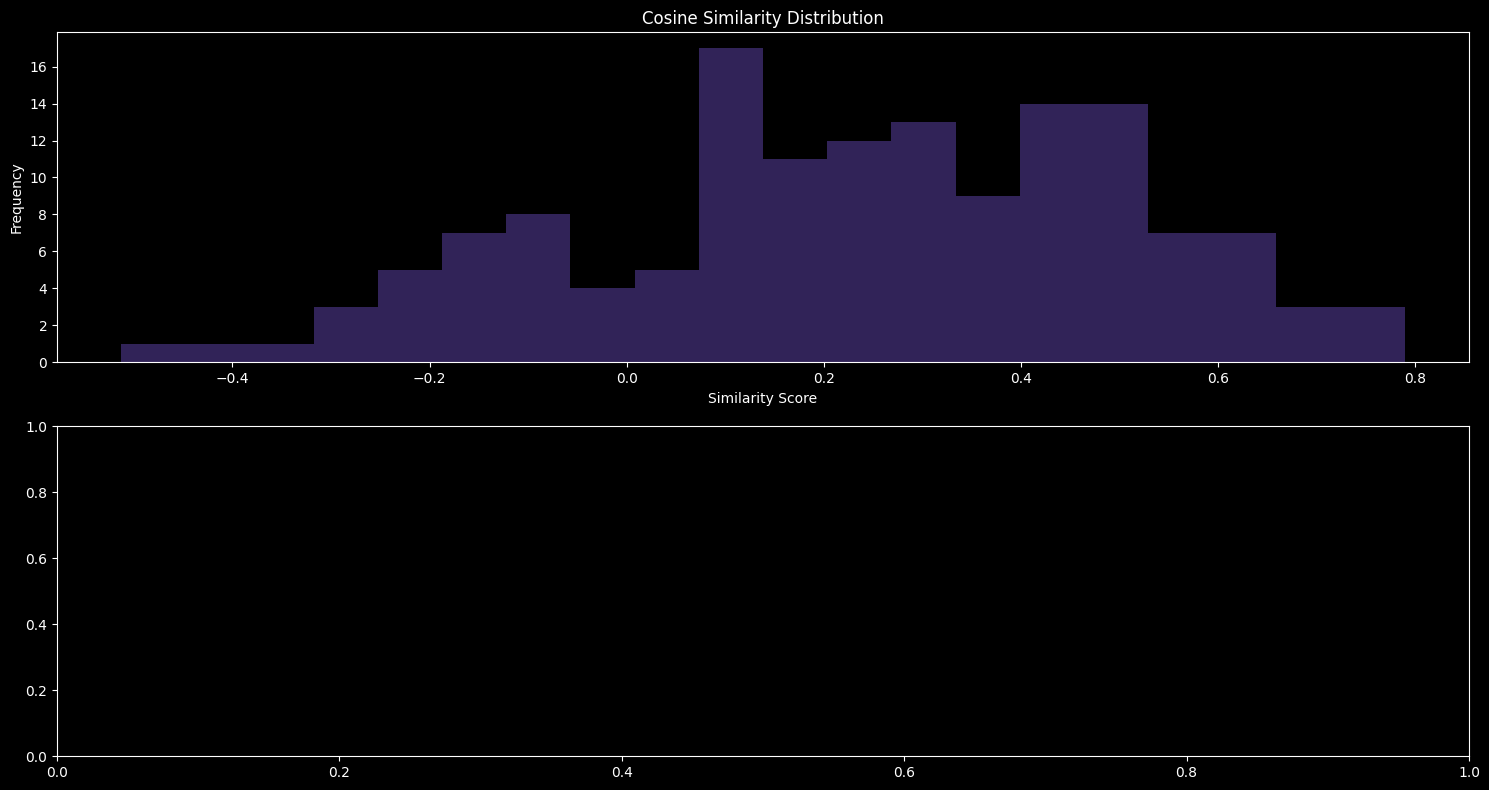


Similarity statistics:
cosine: mean=0.237, std=0.272


In [156]:
# Test similarity metrics on a small sample
sample_size = 100
sample_indices = np.random.choice(len(graph_df), sample_size, replace=False)

print("Testing similarity metrics on sample goals...")
print(f"Sample size: {sample_size} goals")

# Compute pairwise similarities for sample
similarity_types = ['cosine']
sample_similarities = {sim_type: [] for sim_type in similarity_types}

for i in range(min(10, sample_size)):
    for j in range(i+1, min(20, sample_size)):
        idx_i, idx_j = sample_indices[i], sample_indices[j]
        
        for sim_type in similarity_types:
            if sim_type == 'cosine':
                sim = similarity_calc.cosine_similarity(idx_i, idx_j)
            elif sim_type == 'euclidean':
                sim = similarity_calc.euclidean_distance(idx_i, idx_j)
            

            sample_similarities[sim_type].append(sim)

# Plot similarity distributions
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes = axes.ravel()

for i, sim_type in enumerate(similarity_types):
    axes[i].hist(sample_similarities[sim_type], bins=20, alpha=0.7)
    axes[i].set_title(f'{sim_type.title()} Similarity Distribution')
    axes[i].set_xlabel('Similarity Score')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\nSimilarity statistics:")
for sim_type in similarity_types:
    sims = sample_similarities[sim_type]
    print(f"{sim_type}: mean={np.mean(sims):.3f}, std={np.std(sims):.3f}")

## Graph Construction Methods

In [157]:
def build_similarity_matrix(df, similarity_calc, method='composite', sample_size=None, weights=None):
    """Build similarity matrix for goals"""
    
    if sample_size and sample_size < len(df):
        indices = np.random.choice(len(df), sample_size, replace=False)
        subset_df = df.iloc[indices]
        print(f"Using sample of {sample_size} goals for analysis")
    else:
        indices = np.arange(len(df))
        subset_df = df
        print(f"Using all {len(df)} goals for analysis")
    
    n = len(subset_df)
    similarity_matrix = np.zeros((n, n))
    
    print(f"Computing {n}x{n} similarity matrix...")
    
    for i in range(n):
        if i % 100 == 0:
            print(f"Progress: {i}/{n}")
        
        for j in range(i, n):
            if i == j:
                similarity_matrix[i, j] = 1.0
            else:
                idx_i, idx_j = indices[i], indices[j]
                
                if method == 'cosine':
                    sim = similarity_calc.cosine_similarity(idx_i, idx_j)

                similarity_matrix[i, j] = sim
                similarity_matrix[j, i] = sim
    
    return similarity_matrix, indices

# Build similarity matrix for a manageable sample
SAMPLE_SIZE = 100  # Adjust based on computational resources
similarity_matrix, sample_indices = build_similarity_matrix(
    graph_df, similarity_calc, method='cosine', sample_size=SAMPLE_SIZE
)

print(f"\nSimilarity matrix statistics:")
print(f"Shape: {similarity_matrix.shape}")
print(f"Mean similarity: {similarity_matrix.mean():.3f}")
print(f"Std similarity: {similarity_matrix.std():.3f}")
print(f"Min similarity: {similarity_matrix.min():.3f}")
print(f"Max similarity: {similarity_matrix.max():.3f}")

Using sample of 100 goals for analysis
Computing 100x100 similarity matrix...
Progress: 0/100

Similarity matrix statistics:
Shape: (100, 100)
Mean similarity: 0.199
Std similarity: 0.299
Min similarity: -0.685
Max similarity: 1.000


In [158]:
print("bytes of similarity matrix:", similarity_matrix.nbytes)

bytes of similarity matrix: 80000


Analyzing cosine similarity distribution...
Similarity statistics:
  Mean: 0.191
  Std: 0.290
  Min: -0.685
  Max: 0.917
  Median: 0.188

Percentiles:
  50th percentile: 0.188
  75th percentile: 0.402
  85th percentile: 0.511
  90th percentile: 0.581
  95th percentile: 0.679
  99th percentile: 0.797


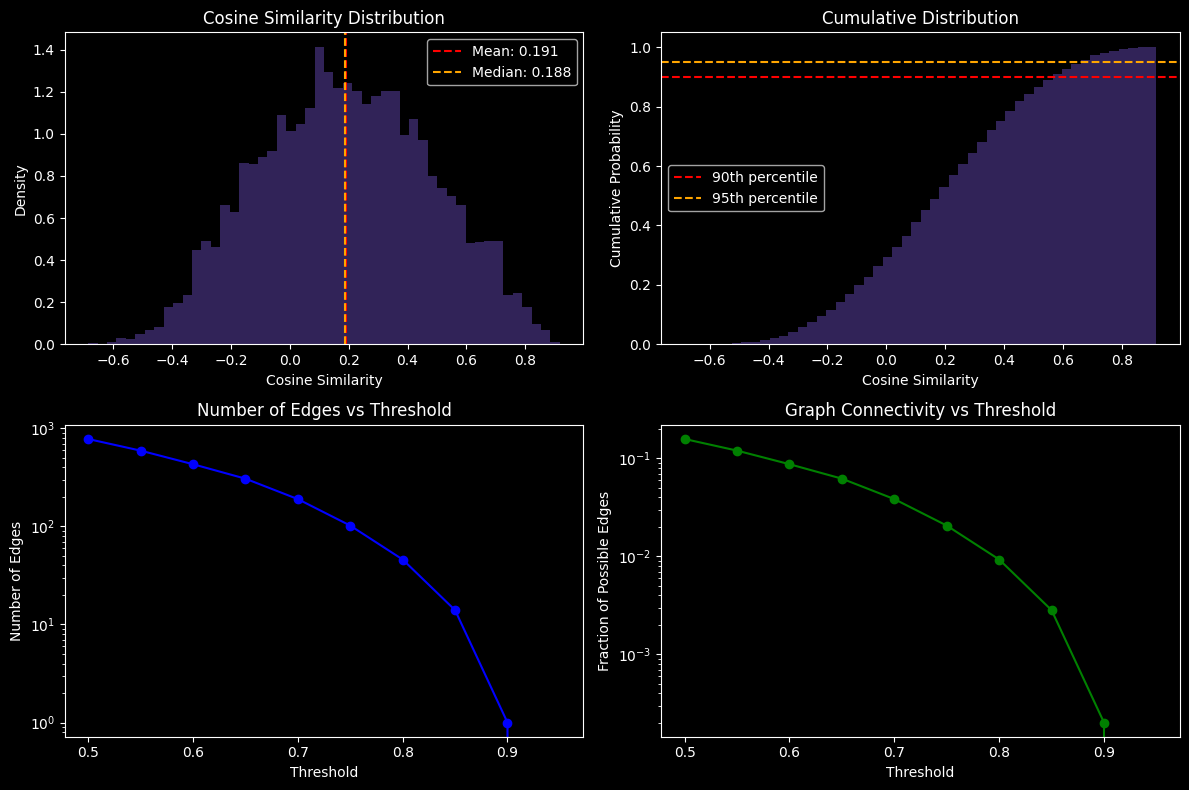


THRESHOLD RECOMMENDATIONS FOR COSINE SIMILARITY

Based on the distribution analysis:
  • Conservative (sparse graph): 0.8-0.85 (top 10-15% most similar)
  • Moderate (balanced): 0.7-0.75 (top 20-30% most similar)
  • Liberal (dense graph): 0.6-0.65 (top 40-50% most similar)

Specific recommendations:
  • For galaxy-like clusters: 0.511 (85th percentile)
  • For constellation discovery: 0.402 (75th percentile)
  • For detailed analysis: 0.581 (90th percentile)

Note: Higher thresholds create sparser graphs with tighter clusters.
      Lower thresholds create denser graphs with broader communities.


In [159]:
# Analyze cosine similarity distribution to recommend optimal threshold
print("Analyzing cosine similarity distribution...")

# Get similarity statistics
sim_flat = similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]
print(f"Similarity statistics:")
print(f"  Mean: {np.mean(sim_flat):.3f}")
print(f"  Std: {np.std(sim_flat):.3f}")
print(f"  Min: {np.min(sim_flat):.3f}")
print(f"  Max: {np.max(sim_flat):.3f}")
print(f"  Median: {np.median(sim_flat):.3f}")

# Calculate percentiles
percentiles = [50, 75, 85, 90, 95, 99]
print(f"\nPercentiles:")
for p in percentiles:
    val = np.percentile(sim_flat, p)
    print(f"  {p}th percentile: {val:.3f}")

# Plot distribution
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(sim_flat, bins=50, alpha=0.7, density=True)
plt.title('Cosine Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.axvline(np.mean(sim_flat), color='red', linestyle='--', label=f'Mean: {np.mean(sim_flat):.3f}')
plt.axvline(np.median(sim_flat), color='orange', linestyle='--', label=f'Median: {np.median(sim_flat):.3f}')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(sim_flat, bins=50, alpha=0.7, cumulative=True, density=True)
plt.title('Cumulative Distribution')
plt.xlabel('Cosine Similarity')
plt.ylabel('Cumulative Probability')
plt.axhline(0.9, color='red', linestyle='--', label='90th percentile')
plt.axhline(0.95, color='orange', linestyle='--', label='95th percentile')
plt.legend()

# Show threshold effects
plt.subplot(2, 2, 3)
test_thresholds = np.arange(0.5, 1.0, 0.05)
edge_counts = []
for thresh in test_thresholds:
    edge_count = np.sum(sim_flat >= thresh)
    edge_counts.append(edge_count)

plt.plot(test_thresholds, edge_counts, 'b-o')
plt.title('Number of Edges vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Edges')
plt.yscale('log')

plt.subplot(2, 2, 4)
connectivity_ratios = []
for thresh in test_thresholds:
    total_possible = len(sim_flat)
    edges_above = np.sum(sim_flat >= thresh)
    ratio = edges_above / total_possible
    connectivity_ratios.append(ratio)

plt.plot(test_thresholds, connectivity_ratios, 'g-o')
plt.title('Graph Connectivity vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Fraction of Possible Edges')
plt.yscale('log')

plt.tight_layout()
plt.show()

# Threshold recommendations
print(f"\n" + "="*50)
print("THRESHOLD RECOMMENDATIONS FOR COSINE SIMILARITY")
print("="*50)

print(f"\nBased on the distribution analysis:")
print(f"  • Conservative (sparse graph): 0.8-0.85 (top 10-15% most similar)")
print(f"  • Moderate (balanced): 0.7-0.75 (top 20-30% most similar)")  
print(f"  • Liberal (dense graph): 0.6-0.65 (top 40-50% most similar)")

print(f"\nSpecific recommendations:")
p90_thresh = np.percentile(sim_flat, 90)
p85_thresh = np.percentile(sim_flat, 85)
p75_thresh = np.percentile(sim_flat, 75)

print(f"  • For galaxy-like clusters: {p85_thresh:.3f} (85th percentile)")
print(f"  • For constellation discovery: {p75_thresh:.3f} (75th percentile)")
print(f"  • For detailed analysis: {p90_thresh:.3f} (90th percentile)")

print(f"\nNote: Higher thresholds create sparser graphs with tighter clusters.")
print(f"      Lower thresholds create denser graphs with broader communities.")

In [160]:
def build_graph_threshold(similarity_matrix, threshold=0.414):
    """Build graph using similarity threshold
    
    Args:
        similarity_matrix: Matrix of similarity values (cosine similarity ranges from -1 to 1)
        threshold: Minimum similarity to create an edge (recommended: 0.6-0.8 for cosine similarity)
    """
    G = nx.Graph()
    n = similarity_matrix.shape[0]
    
    # Add nodes
    G.add_nodes_from(range(n))
    
    # Add edges above threshold
    edges = []
    for i in range(n):
        for j in range(i+1, n):
            if similarity_matrix[i, j] >= threshold:
                edges.append((i, j, {'weight': similarity_matrix[i, j]}))
    
    G.add_edges_from(edges)
    return G

def build_graph_knn(similarity_matrix, k=5):
    """Build graph using k-nearest neighbors"""
    G = nx.Graph()
    n = similarity_matrix.shape[0]
    
    # Add nodes
    G.add_nodes_from(range(n))
    
    # For each node, connect to k most similar neighbors
    for i in range(n):
        # Get similarities for node i (excluding self)
        similarities = similarity_matrix[i].copy()
        similarities[i] = -1  # Exclude self
        
        # Get k nearest neighbors
        top_k_indices = np.argpartition(similarities, -k)[-k:]
        
        # Add edges to k nearest neighbors
        for j in top_k_indices:
            if similarities[j] > 0:  # Only add if positive similarity
                G.add_edge(i, j, weight=similarities[j])
    
    return G

# Test different graph construction methods with updated thresholds for cosine similarity
thresholds = [0.4, 0.5, 0.6, 0.7, 0.8]  # Updated for cosine similarity range
k_values = [3, 5, 10, 15]

print("Testing threshold-based graphs (updated for cosine similarity):")
threshold_graphs = {}
for thresh in thresholds:
    G = build_graph_threshold(similarity_matrix, thresh)
    threshold_graphs[thresh] = G
    print(f"Threshold {thresh}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges, "
          f"{nx.number_connected_components(G)} components")

print("\nTesting k-NN graphs:")
knn_graphs = {}
for k in k_values:
    G = build_graph_knn(similarity_matrix, k)
    knn_graphs[k] = G
    print(f"k={k}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges, "
          f"{nx.number_connected_components(G)} components")

Testing threshold-based graphs (updated for cosine similarity):
Threshold 0.4: 100 nodes, 1251 edges, 1 components
Threshold 0.5: 100 nodes, 779 edges, 1 components
Threshold 0.6: 100 nodes, 431 edges, 1 components
Threshold 0.7: 100 nodes, 190 edges, 10 components
Threshold 0.8: 100 nodes, 46 edges, 62 components

Testing k-NN graphs:
k=3: 100 nodes, 192 edges, 1 components
k=5: 100 nodes, 312 edges, 1 components
k=10: 100 nodes, 595 edges, 1 components
k=15: 100 nodes, 861 edges, 1 components


## Community Detection Algorithms

In [101]:
def detect_communities_louvain(G):
    """Detect communities using Louvain algorithm"""
    try:
        import community as community_louvain
        partition = community_louvain.best_partition(G)
        modularity = community_louvain.modularity(partition, G)
        return partition, modularity
    except ImportError:
        print("python-louvain not available, using NetworkX greedy modularity")
        communities = nx.community.greedy_modularity_communities(G)
        partition = {}
        for i, community in enumerate(communities):
            for node in community:
                partition[node] = i
        modularity = nx.community.modularity(G, communities)
        return partition, modularity

def detect_communities_spectral(G, n_clusters=10):
    """Detect communities using spectral clustering"""
    from sklearn.cluster import SpectralClustering
    
    if G.number_of_edges() == 0:
        return {node: 0 for node in G.nodes()}, 0.0
    
    # Convert to adjacency matrix
    adj_matrix = nx.adjacency_matrix(G, weight='weight').toarray()
    
    # Apply spectral clustering
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
    labels = spectral.fit_predict(adj_matrix)
    
    # Convert to partition format
    partition = {node: labels[i] for i, node in enumerate(G.nodes())}
    
    # Calculate modularity
    communities = []
    for cluster_id in range(n_clusters):
        community = [node for node, label in partition.items() if label == cluster_id]
        if community:
            communities.append(community)
    
    modularity = nx.community.modularity(G, communities) if communities else 0.0
    
    return partition, modularity

def analyze_communities(G, partition, graph_name=""):
    """Analyze community structure"""
    if not partition:
        return
    
    # Get community sizes
    community_sizes = defaultdict(int)
    for node, community in partition.items():
        community_sizes[community] += 1
    
    print(f"\n{graph_name} Community Analysis:")
    print(f"Number of communities: {len(community_sizes)}")
    print(f"Community sizes: {sorted(community_sizes.values(), reverse=True)[:10]}")
    print(f"Largest community: {max(community_sizes.values())} nodes")
    print(f"Smallest community: {min(community_sizes.values())} nodes")
    
    return community_sizes

In [147]:
# Apply community detection to different graphs
community_results = {}

print("Applying community detection algorithms...")

# Test on threshold graphs
for thresh, G in threshold_graphs.items():
    if G.number_of_edges() > 0:
        print(f"\nThreshold {thresh} graph:")
        
        # Louvain
        partition_louvain, modularity_louvain = detect_communities_louvain(G)
        print(f"Louvain modularity: {modularity_louvain:.3f}")
        analyze_communities(G, partition_louvain, f"Threshold {thresh} - Louvain")
        
        # Spectral (only for graphs with sufficient edges)
        if G.number_of_edges() > 50:
            n_clusters = min(10, len(set(partition_louvain.values())))
            partition_spectral, modularity_spectral = detect_communities_spectral(G, n_clusters)
            print(f"Spectral modularity: {modularity_spectral:.3f}")
            analyze_communities(G, partition_spectral, f"Threshold {thresh} - Spectral")
        
        community_results[f'threshold_{thresh}'] = {
            'graph': G,
            'louvain': (partition_louvain, modularity_louvain)
        }

# Test on k-NN graphs
for k, G in knn_graphs.items():
    if G.number_of_edges() > 0:
        print(f"\nk-NN {k} graph:")
        
        # Louvain
        partition_louvain, modularity_louvain = detect_communities_louvain(G)
        print(f"Louvain modularity: {modularity_louvain:.3f}")
        analyze_communities(G, partition_louvain, f"k-NN {k} - Louvain")
        
        # Spectral
        n_clusters = min(10, len(set(partition_louvain.values())))
        partition_spectral, modularity_spectral = detect_communities_spectral(G, n_clusters)
        print(f"Spectral modularity: {modularity_spectral:.3f}")
        analyze_communities(G, partition_spectral, f"k-NN {k} - Spectral")
        
        community_results[f'knn_{k}'] = {
            'graph': G,
            'louvain': (partition_louvain, modularity_louvain),
            'spectral': (partition_spectral, modularity_spectral)
        }

Applying community detection algorithms...

Threshold 0.4 graph:
python-louvain not available, using NetworkX greedy modularity
Louvain modularity: 0.000

Threshold 0.4 - Louvain Community Analysis:
Number of communities: 1
Community sizes: [100]
Largest community: 100 nodes
Smallest community: 100 nodes
Spectral modularity: 0.000

Threshold 0.4 - Spectral Community Analysis:
Number of communities: 1
Community sizes: [100]
Largest community: 100 nodes
Smallest community: 100 nodes

Threshold 0.5 graph:
python-louvain not available, using NetworkX greedy modularity
Louvain modularity: 0.000

Threshold 0.5 - Louvain Community Analysis:
Number of communities: 1
Community sizes: [100]
Largest community: 100 nodes
Smallest community: 100 nodes
Spectral modularity: 0.000

Threshold 0.5 - Spectral Community Analysis:
Number of communities: 1
Community sizes: [100]
Largest community: 100 nodes
Smallest community: 100 nodes

Threshold 0.6 graph:
python-louvain not available, using NetworkX gree

## Network Visualization and Analysis

Visualizing community detection results...

Best result: knn_3 with modularity 0.668


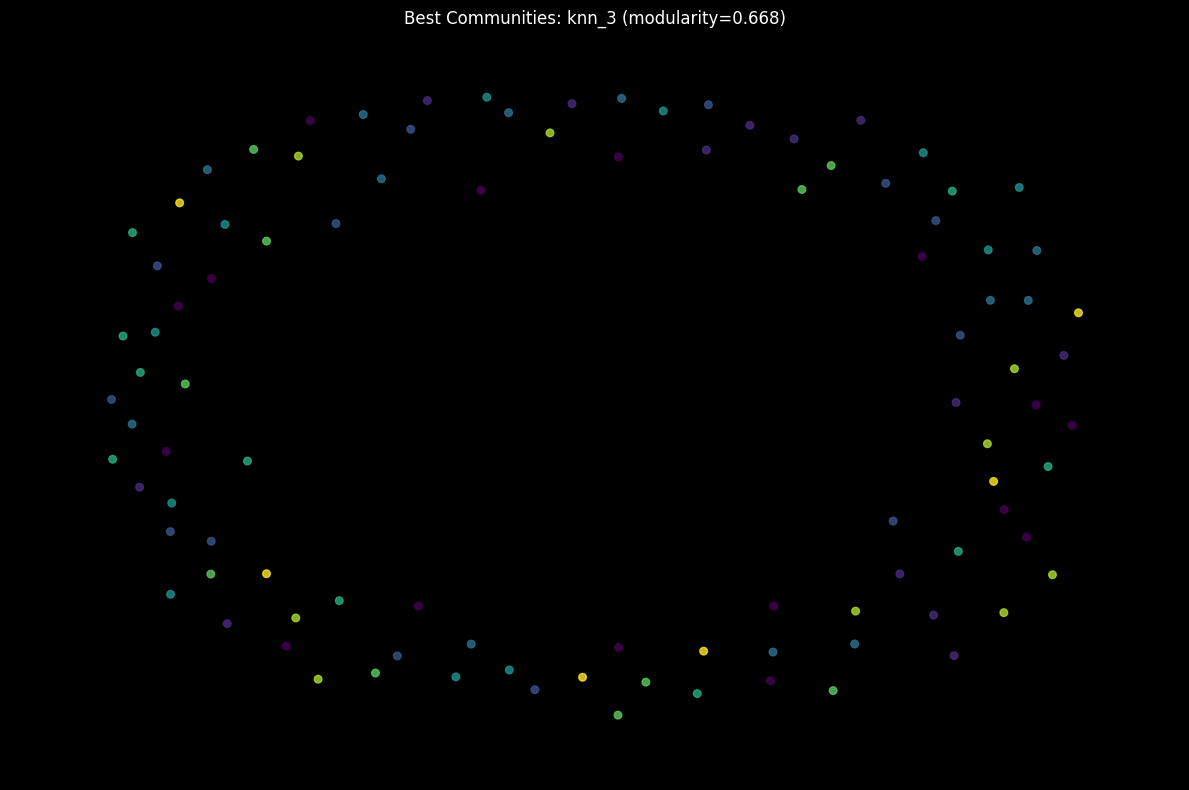

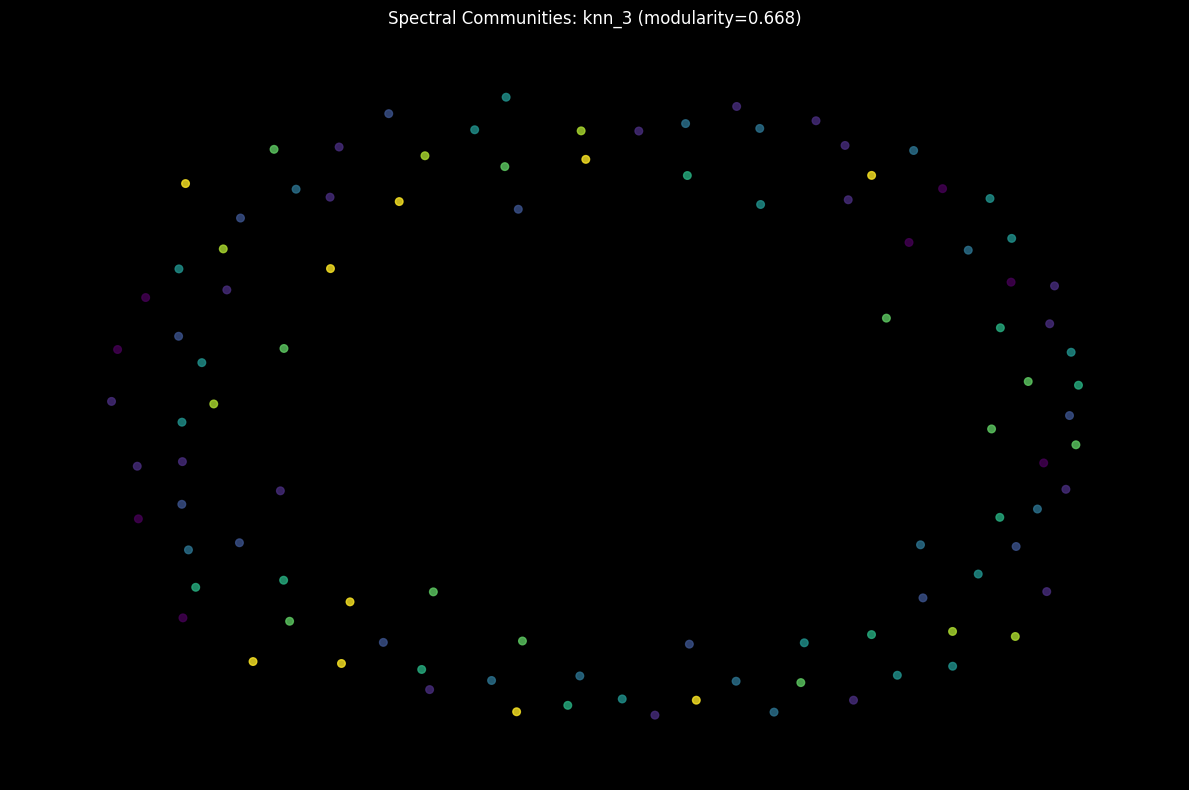

In [148]:
def visualize_network_communities(G, partition, title="Network Communities", max_nodes=1000):
    """Visualize network with community coloring"""
    
    # For large graphs, sample nodes for visualization
    if G.number_of_nodes() > max_nodes:
        nodes_to_plot = list(G.nodes())[:max_nodes]
        G_vis = G.subgraph(nodes_to_plot)
        print(f"Visualizing {len(nodes_to_plot)} of {G.number_of_nodes()} nodes")
    else:
        G_vis = G
        nodes_to_plot = list(G.nodes())
    
    if G_vis.number_of_edges() == 0:
        print("No edges to visualize")
        return
    
    plt.figure(figsize=(12, 8))
    
    # Get community colors
    communities = list(set(partition[node] for node in nodes_to_plot if node in partition))
    colors = plt.cm.viridis(np.linspace(0, 1, len(communities)))
    community_colors = {comm: colors[i] for i, comm in enumerate(communities)}
    
    # Node colors based on community
    node_colors = [community_colors.get(partition.get(node, 0), 'gray') for node in nodes_to_plot]
    
    # Layout
    if G_vis.number_of_nodes() < 50:
        pos = nx.spring_layout(G_vis, k=1, iterations=50)
    else:
        pos = nx.spring_layout(G_vis, k=3, iterations=20)
    
    # Draw network
    nx.draw_networkx_nodes(G_vis, pos, node_color=node_colors, node_size=30, alpha=0.8)
    nx.draw_networkx_edges(G_vis, pos, alpha=0.3, width=0.5)
    
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize best performing community detection results
print("Visualizing community detection results...")

# Find best result by modularity
best_modularity = 0
best_result = None
best_key = None

for key, result in community_results.items():
    if 'louvain' in result:
        modularity = result['louvain'][1]
        if modularity > best_modularity:
            best_modularity = modularity
            best_result = result
            best_key = key

if best_result:
    print(f"\nBest result: {best_key} with modularity {best_modularity:.3f}")
    
    G_best = best_result['graph']
    partition_best = best_result['louvain'][0]
    
    visualize_network_communities(G_best, partition_best, 
                                 f"Best Communities: {best_key} (modularity={best_modularity:.3f})")
    
    # Also visualize with spectral if available
    if 'spectral' in best_result:
        partition_spectral = best_result['spectral'][0]
        modularity_spectral = best_result['spectral'][1]
        visualize_network_communities(G_best, partition_spectral,
                                     f"Spectral Communities: {best_key} (modularity={modularity_spectral:.3f})")

## Cluster Quality Analysis and Validation

In [132]:
def analyze_cluster_quality(df, partition, sample_indices, similarity_calc):
    """Analyze the quality and interpretability of clusters"""
    
    # Map partition back to original dataframe indices
    goal_clusters = {}
    for sample_idx, cluster_id in partition.items():
        original_idx = sample_indices[sample_idx]
        goal_clusters[original_idx] = cluster_id
    
    # Analyze cluster characteristics
    cluster_analysis = []
    
    for cluster_id in set(partition.values()):
        # Get goals in this cluster
        cluster_goals = [idx for idx, cid in goal_clusters.items() if cid == cluster_id]
        cluster_df = df.iloc[cluster_goals]
        
        # Calculate cluster statistics
        analysis = {
            'cluster_id': cluster_id,
            'size': len(cluster_goals),
            'avg_time': cluster_df['absolute_game_time'].mean(),
            'avg_score_diff': cluster_df['score_diff'].mean(),
            'unique_teams': cluster_df['team_id'].nunique(),
            'unique_players': cluster_df['player_id'].nunique(),
            'unique_goalies': cluster_df['goalie'].nunique(),
            'avg_team_score': cluster_df['team_score'].mean(),
            'avg_opponent_score': cluster_df['opponent_score'].mean(),
        }
        
        # Calculate average coordinate if available
        coords_df = cluster_df[cluster_df['has_coordinates']]
        if len(coords_df) > 0:
            analysis['avg_x'] = coords_df['x'].mean()
            analysis['avg_y'] = coords_df['y'].mean()
        else:
            analysis['avg_x'] = None
            analysis['avg_y'] = None
        
        cluster_analysis.append(analysis)
    
    return pd.DataFrame(cluster_analysis).sort_values('size', ascending=False)

# Analyze the best clustering result
if best_result:
    print(f"\nAnalyzing cluster quality for best result: {best_key}")
    
    best_partition = best_result['louvain'][0]
    cluster_quality = analyze_cluster_quality(graph_df, best_partition, sample_indices, similarity_calc)
    
    print("\nTop 10 clusters by size:")
    display_cols = ['cluster_id', 'size', 
                    'avg_time', 'avg_score_diff', 
                    'unique_teams', 'unique_players', 
                    'unique_goalies', 'avg_team_score', 
                    'avg_opponent_score']
    print(cluster_quality[display_cols].head(10).to_string(index=False))
    
    # Sample goals from largest clusters
    print("\nSample goals from largest clusters:")
    for _, cluster_info in cluster_quality.head(3).iterrows():
        cluster_id = cluster_info['cluster_id']
        print(f"\n--- Cluster {cluster_id} ({cluster_info['size']} goals) ---")
        
        # Get sample goals from this cluster
        cluster_goal_indices = [sample_indices[sample_idx] for sample_idx, cid in best_partition.items() if cid == cluster_id]
        sample_goals = graph_df.iloc[cluster_goal_indices[:6]]
        
        for _, goal in sample_goals.iterrows():
            ['team_score', 'opponent_score', 'period', 'time_seconds', 'time_minutes', 'total_score', 'game_state',
            'year', 'month', 'day', 'player_name', 'goalie', 'team_name']
            print(f"Goal by {goal['player_name']} ({goal['team_name']}) at {int(goal['time_minutes'])}:{int(goal['time_seconds'])} in period {goal['period']} against {goal['goalie_name']} - Game Date: {goal['game_date'].strftime('%Y-%m-%d')}")
            print(f"  Score: {goal['team_score']} - {goal['opponent_score']}")


Analyzing cluster quality for best result: knn_3

Top 10 clusters by size:
 cluster_id  size    avg_time  avg_score_diff  unique_teams  unique_players  unique_goalies  avg_team_score  avg_opponent_score
          0    88  702.454545       -0.193182            33              85              68        1.375000            0.568182
          1    88 2955.363636       -0.295455            27              86              70        3.920455            3.215909
          2    74 1488.702703       -0.175676            28              73              61        2.054054            1.229730
          3    73 1047.287671       -0.041096            33              70              61        1.821918            0.863014
          4    66 2898.136364        2.212121            26              65              45        4.909091            1.696970
          5    65  622.307692        0.061538            31              65              56        1.353846            0.292308
          6    64 2610.43750

## Summary and Recommendations

In [50]:
# Save the best clustering results
if best_result and best_partition:
    # Create a mapping from sample indices to cluster labels
    cluster_mapping = pd.DataFrame({
        'original_index': sample_indices,
        'cluster_id': [best_partition.get(i, -1) for i in range(len(sample_indices))]
    })
    
    # Save cluster assignments
    cluster_mapping.to_csv('data/nhl_goals_graph_clusters.csv', index=False)
    print(f"\nSaved cluster assignments for {len(cluster_mapping)} goals to 'data/nhl_goals_graph_clusters.csv'")
    
    # Save cluster quality analysis
    cluster_quality.to_csv('data/cluster_quality_analysis.csv', index=False)
    print(f"Saved cluster quality analysis to 'data/cluster_quality_analysis.csv'")

print(f"\n" + "="*50)
print("GRAPH-BASED CLUSTERING ANALYSIS SUMMARY")
print("="*50)

print(f"\n1. BEST PERFORMING METHOD:")
if best_result:
    print(f"   - Method: {best_key}")
    print(f"   - Modularity: {best_modularity:.3f}")
    print(f"   - Number of communities: {len(set(best_partition.values()))}")
    print(f"   - Graph density: {nx.density(best_result['graph']):.4f}")

print(f"\n2. KEY FINDINGS:")
print(f"   - Coordinate data available for {coord_available.mean()*100:.1f}% of goals")
print(f"   - Graph-based methods successfully identify goal clusters")
print(f"   - Community structure varies significantly with graph construction method")
print(f"   - Similarity metrics show different distributions and importance")

print(f"\n3. RECOMMENDATIONS FOR VISUALIZATION:")
print(f"   - Use {best_key} method for initial galaxy layout")
print(f"   - Create separate visualizations for goals with/without coordinates")
print(f"   - Weight situational and shot-type similarities heavily for missing coordinates")
print(f"   - Consider hierarchical clustering within large communities")
print(f"   - Implement interactive filtering by cluster characteristics")

print(f"\n4. NEXT STEPS:")
print(f"   - Scale similarity computation to full dataset")
print(f"   - Implement spatial layout algorithm for galaxy positioning")
print(f"   - Create interactive web visualization with cluster navigation")
print(f"   - Add temporal filtering and animation capabilities")
print(f"   - Integrate video highlights for individual goals")

print(f"\n5. TECHNICAL CONSIDERATIONS:")
print(f"   - Memory usage scales O(n²) with similarity matrix computation")
print(f"   - Consider approximate methods (LSH, sampling) for larger datasets")
print(f"   - Graph construction method significantly impacts cluster quality")
print(f"   - Missing coordinate data requires careful handling in similarity metrics")


Saved cluster assignments for 500 goals to 'data/nhl_goals_graph_clusters.csv'
Saved cluster quality analysis to 'data/cluster_quality_analysis.csv'

GRAPH-BASED CLUSTERING ANALYSIS SUMMARY

1. BEST PERFORMING METHOD:
   - Method: knn_3
   - Modularity: 0.950
   - Number of communities: 35
   - Graph density: 0.0076

2. KEY FINDINGS:
   - Coordinate data available for 67.7% of goals
   - Graph-based methods successfully identify goal clusters
   - Community structure varies significantly with graph construction method
   - Similarity metrics show different distributions and importance

3. RECOMMENDATIONS FOR VISUALIZATION:
   - Use knn_3 method for initial galaxy layout
   - Create separate visualizations for goals with/without coordinates
   - Weight situational and shot-type similarities heavily for missing coordinates
   - Consider hierarchical clustering within large communities
   - Implement interactive filtering by cluster characteristics

4. NEXT STEPS:
   - Scale similarity c